## Importing the dataset from the internet
### For this we will be using pathlib library for import certain files from the internet using it file path or url.


In [81]:
import requests
from pathlib import Path
if Path("banknote_authentication.csv").is_file():
  print("banknote_authentication already exists, skipping download")
else:
  print("Downloading banknote_authentication")
  request = requests.get("https://raw.githubusercontent.com/dudeanurag/Fake-Currency-Identification/master/banknote_authentication.csv")
  with open("banknote_authentication.csv", "wb") as f:
    f.write(request.content)


banknote_authentication already exists, skipping download


##Loading the dataset to the notebook
###Using pandas and other libraries:
- We first load the dataset into the notebook.
- Perform basic EDA and visualize the features.
- Find any null values.
- Preprocess the data for it to fit to the model.


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("banknote_authentication.csv")
data.head()


,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   kurtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [84]:
data.isnull().values.any()

False

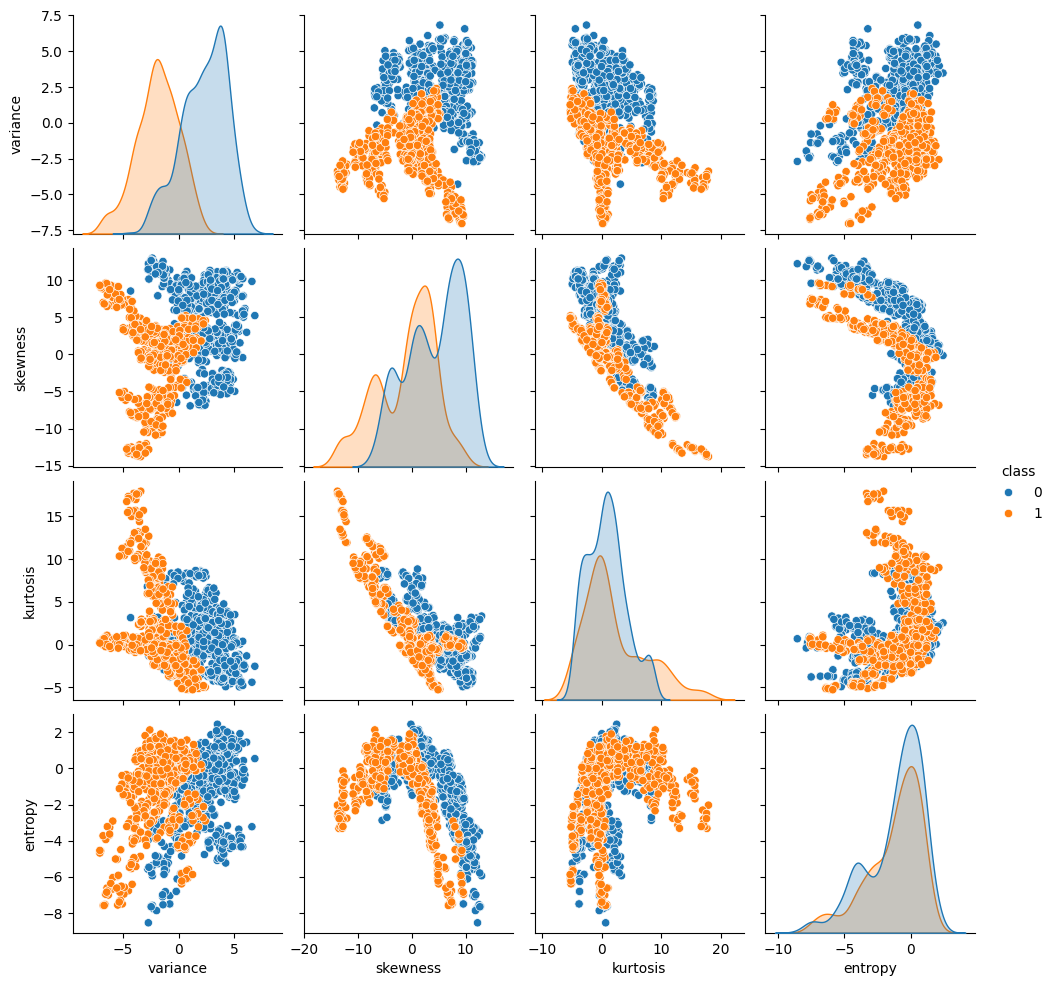

In [85]:
sns.pairplot(data, hue='class')
plt.show()

These pairplots give us an insight of how the fake notes vary from the original ones depending on various features. The blue parts or dots on the graphs indicate that those datapoints are authentic currency and the orange dots are fake currency

From this pair plot we can make several interesting observations:

- The distribution of both variance and skewness appears to be quite different for the two target characteristics, while kurtosis and entropy appear to be more similar.
- There are clear linear and nonlinear trends in the input features.
- Some characteristics seem to be correlated.
- Some features seem to separate genuine and fake banknotes quite well.

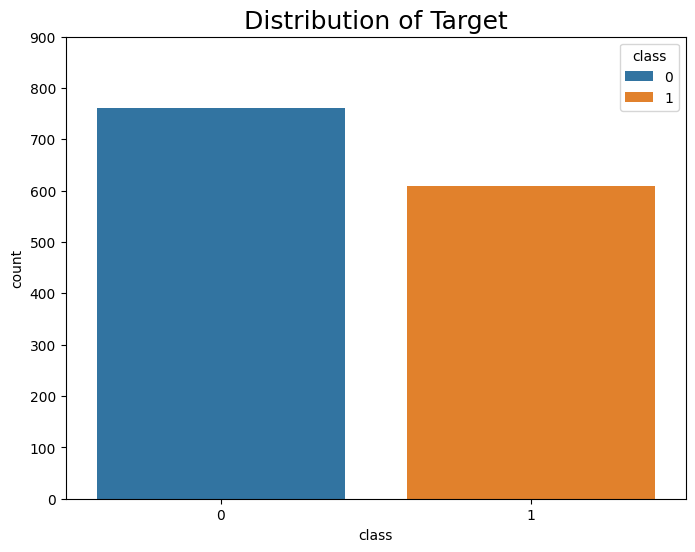

In [86]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Target', size=18)
sns.countplot(data, x='class',hue='class')
target_count = data['class'].value_counts()
plt.ylim(0,900)
plt.show()

###The dataset is fairly balanced, but for the binary classification task, we need to balance it perfectly.

#Data Processing

In [87]:
to_delete = target_count[0] - target_count[1]
data = data.sample(frac=1, random_state=42).sort_values(by='class')
data = data[to_delete:]
print(data['class'].value_counts())

class
0    610
1    610
Name: count, dtype: int64


##Divide the data into training and test sets:
###We now split the dataset into Features and labels. By doing this we can train the models or neural network on the features and then make predictions on the labels





In [88]:
x = data.loc[:, data.columns != 'class']
y = data.loc[:, data.columns == 'class']
y = y.squeeze()

Now let's view the first 5 X and y values.



In [89]:
print(f"First 5 X features:\n{x[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
     variance  skewness  kurtosis  entropy
311   5.02970  -4.97040    3.5025 -0.23751
30   -0.24811  -0.17797    4.9068  0.15429
242   1.64060   3.54880    1.3964 -0.36424
136   5.43800   9.46690   -4.9417 -3.92020
310   4.02150  -2.70040    2.4957  0.36636

First 5 y labels:
311    0
30     0
242    0
136    0
310    0
Name: class, dtype: int64


In [149]:
import torch
# Turn data into tensors

X = torch.tensor(x.values).type(torch.float)
Y = torch.tensor(y.values).type(torch.float)

# View the first five samples
X[:5], Y[:5]

(tensor([[ 5.0297, -4.9704,  3.5025, -0.2375],
         [-0.2481, -0.1780,  4.9068,  0.1543],
         [ 1.6406,  3.5488,  1.3964, -0.3642],
         [ 5.4380,  9.4669, -4.9417, -3.9202],
         [ 4.0215, -2.7004,  2.4957,  0.3664]]),
 tensor([0., 0., 0., 0., 0.]))

In [95]:
X.shape, Y.shape

(torch.Size([1220, 4]), torch.Size([1220]))

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(976, 244, 976, 244)

In [113]:
y_test = torch.tensor(y_test.values, dtype=torch.float32)


There are several evaluation metrics that can be used for classification problems but let's start out with accuracy.

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.

Let's write a function to do so.

In [107]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [108]:
from torch import nn
class Classification_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=4, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = Classification_Model()
print(model)

Classification_Model(
  (layer_1): Linear(in_features=4, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


This class is basically our neural network model. This model is made by constructing a model by subclassing nn.Module.


In [109]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [114]:
torch.manual_seed(42)
epochs = 1000


for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.72493, Accuracy: 49.28% | Test Loss: 0.71153, Test Accuracy: 52.46%
Epoch: 100 | Loss: 0.05732, Accuracy: 99.39% | Test Loss: 0.06509, Test Accuracy: 98.77%
Epoch: 200 | Loss: 0.01947, Accuracy: 99.49% | Test Loss: 0.02336, Test Accuracy: 98.77%
Epoch: 300 | Loss: 0.01135, Accuracy: 99.59% | Test Loss: 0.01294, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00778, Accuracy: 100.00% | Test Loss: 0.00819, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00572, Accuracy: 100.00% | Test Loss: 0.00562, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.00433, Accuracy: 100.00% | Test Loss: 0.00403, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.00344, Accuracy: 100.00% | Test Loss: 0.00304, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.00279, Accuracy: 100.00% | Test Loss: 0.00238, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.00234, Accuracy: 100.00% | Test Loss: 0.00192, Test Accuracy: 100.00%


In [141]:
input_data = torch.tensor([5.02970, -4.97040, 3.5025, -0.23751])

In [142]:
input_data.shape

torch.Size([4])

The final step is to check whether our trained model is upto its accuracy or not. We can do this by giving some random inputs to the model and get the output from the model.

In [143]:
model.eval()
with torch.inference_mode():
  prediction = model(input_data)
logits = prediction.item()  # Assuming single output for binary classification

# Apply softmax activation for probability distribution (optional)
probability = torch.nn.functional.sigmoid(torch.tensor([logits]))[0]  # Assuming single prediction

# Define a threshold (optional) for binary classification
threshold = 0.5

# Classify based on threshold or probability. 0 for real and 1 for fake
if logits > threshold or probability > threshold:
  print("The following currency note is a counterfeit. ")
else:
  print("The following currency note is authentic. ")

The following currency note is authentic. 


In [144]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5193,  0.8215,  0.6211,  0.2341],
                      [-0.0998,  0.0436, -0.0889,  0.3019],
                      [ 0.6825, -0.3072,  0.3881, -0.1121],
                      [ 0.2286,  0.1240,  0.3707, -0.1151],
                      [ 0.3913, -0.0547, -0.3492,  0.1571],
                      [-0.1990, -0.0295, -0.2587,  0.3405],
                      [-1.2975, -0.4168, -0.1906, -0.0036],
                      [ 0.0955, -0.4632,  0.3887, -0.4662],
                      [ 0.5510,  0.2699, -0.4417,  0.1838],
                      [ 0.7199,  0.3361,  0.6431, -0.3276]])),
             ('layer_1.bias',
              tensor([-1.0175e-04, -2.1014e-01,  2.4765e-01,  4.5271e-01,  3.5023e-01,
                      -1.9783e-01,  9.0243e-01,  9.0945e-02,  4.3219e-01, -1.0650e-01])),
             ('layer_2.weight',
              tensor([[-0.3567, -0.0722, -0.2667,  0.1755,  0.3960,  0.1804,  0.7425,  0.0678,
                        0.5936,

##Saving the model for future use or to use it in other applications or platforms

In [145]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "Fake currecny identifier"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/Fake currecny identifier


In [148]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/My Drive
model_save_name = 'Fake currecny identifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)

Mounted at /content/gdrive
ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive': No such file or directory
